In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from numpy.polynomial import Polynomial
from scipy.constants import speed_of_light
from shapely.geometry import box
from shapely.ops import clip_by_rect
from skfem import Basis, ElementTriP0
from skfem.io.meshio import from_meshio
from tqdm import tqdm

from femwell.maxwell.waveguide import compute_modes
from femwell.mesh import mesh_from_OrderedDict

In [8]:
def n_silicon_nitride(wavelength):
    x = wavelength
    return (1 + 3.0249 / (1 - (0.1353406 / x) ** 2) + 40314 / (1 - (1239.842 / x) ** 2)) ** 0.5


def n_silicon_dioxide(wavelength):
    x = wavelength
    return (
        1
        + 0.6961663 / (1 - (0.0684043 / x) ** 2)
        + 0.4079426 / (1 - (0.1162414 / x) ** 2)
        + 0.8974794 / (1 - (9.896161 / x) ** 2)
    ) ** 0.5



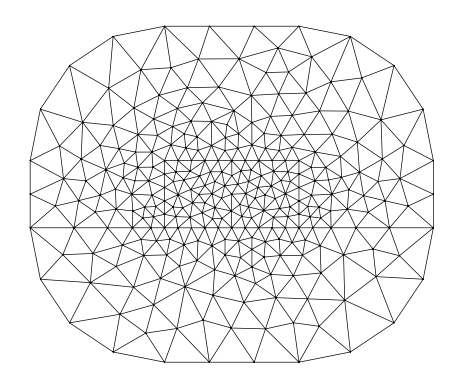

In [9]:
width = 1
height = 0.5
core = box(0, 0, width, height)
polygons = OrderedDict(
    core=core,
    box=clip_by_rect(core.buffer(1.0, resolution=4), -np.inf, -np.inf, np.inf, 0),
    clad=clip_by_rect(core.buffer(1.0, resolution=4), -np.inf, 0, np.inf, np.inf),
)

resolutions = {"core": {"resolution": 0.1, "distance": 1}}

mesh = from_meshio(mesh_from_OrderedDict(polygons, resolutions, default_resolution_max=0.6))
mesh.draw().show()

In [4]:
wavelengths = np.linspace(1.2, 1.9, 20)
num_modes = 2

all_neffs = np.zeros((wavelengths.shape[0], num_modes))
all_te_fracs = np.zeros((wavelengths.shape[0], num_modes))
for i, wavelength in enumerate(tqdm(wavelengths)):
    basis0 = Basis(mesh, ElementTriP0())
    epsilon = basis0.zeros(dtype=complex)
    for subdomain, n in {
        "core": n_silicon_nitride(wavelength),
        "box": n_silicon_dioxide(wavelength),
        "clad": 1,
    }.items():
        epsilon[basis0.get_dofs(elements=subdomain)] = n**2

    modes = compute_modes(basis0, epsilon, wavelength=wavelength, num_modes=num_modes)
    all_neffs[i] = np.real([mode.n_eff for mode in modes])
    all_te_fracs[i, :] = [mode.te_fraction for mode in modes]

100%|██████████| 20/20 [00:01<00:00, 11.45it/s]


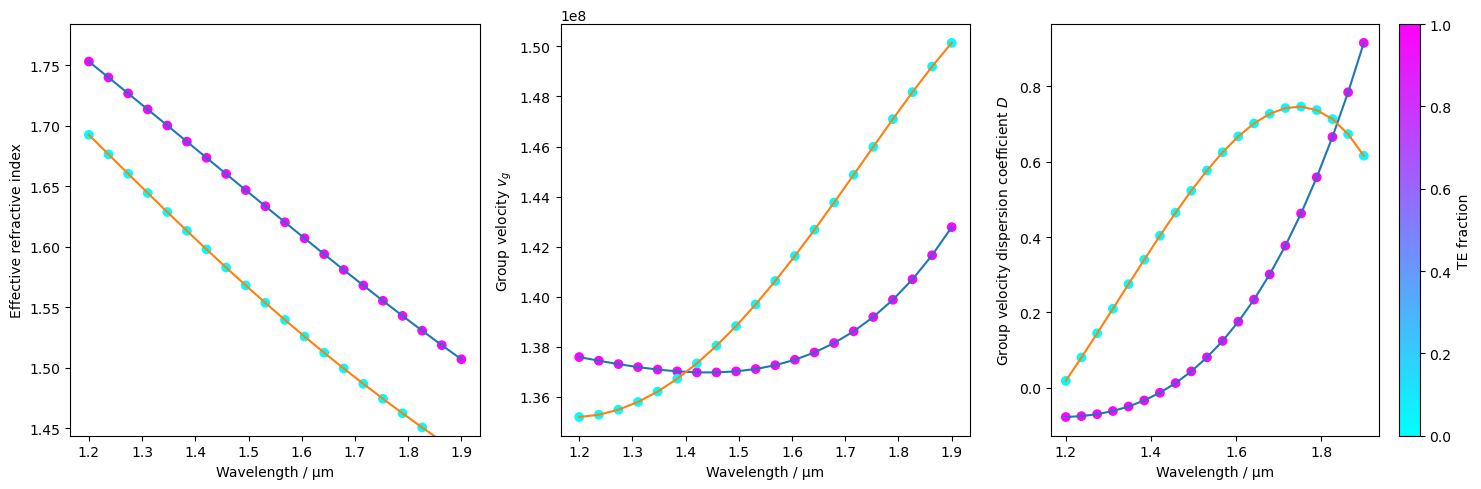

In [7]:
all_neffs = np.real(all_neffs)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].set_xlabel("Wavelength / µm")
axs[0].set_ylabel("Effective refractive index")
axs[0].set_ylim(1.444, np.max(all_neffs) + 0.1 * (np.max(all_neffs) - 1.444))
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    axs[0].plot(wavelengths, lams)
    sc = axs[0].scatter(wavelengths, lams, c=te_fracs, cmap="cool", vmin=0, vmax=1)


axs[1].set_xlabel("Wavelength / µm")
axs[1].set_ylabel("Group velocity $v_g$")
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    fit = Polynomial.fit(wavelengths, lams, deg=4)
    y = speed_of_light / (lams - wavelengths * fit.deriv(1)(wavelengths))
    axs[1].plot(wavelengths, y)
    sc = axs[1].scatter(wavelengths, y, c=te_fracs, cmap="cool", vmin=0, vmax=1)

axs[2].set_xlabel("Wavelength / µm")
axs[2].set_ylabel("Group velocity dispersion coefficient $D$")
for lams, te_fracs in zip(all_neffs.T, all_te_fracs.T):
    fit = Polynomial.fit(wavelengths, lams, deg=4)
    y = wavelengths**2 * fit.deriv(2)(wavelengths)
    axs[2].plot(wavelengths, y)
    sc = axs[2].scatter(wavelengths, y, c=te_fracs, cmap="cool", vmin=0, vmax=1)
fig.colorbar(sc).set_label("TE fraction")
plt.tight_layout()
plt.show()